In [1]:
!pip install -q tensorflow scikit-learn pandas matplotlib

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [8]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv"
df = pd.read_csv(url)

print("Dataset shape:", df.shape)
print(df["Class"].value_counts())


Dataset shape: (284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64


In [9]:
X = df.drop("Class", axis=1).values
y = df["Class"].values


In [10]:
scaler = StandardScaler()
X[:, [0, -1]] = scaler.fit_transform(X[:, [0, -1]])


In [11]:
X_train = X[y == 0]
X_test = X
y_test = y

print("Training data (non-fraud):", X_train.shape)


Training data (non-fraud): (284315, 30)


In [12]:
input_dim = X_train.shape[1]

autoencoder = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(16, activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(input_dim, activation="linear")
])

autoencoder.compile(optimizer="adam", loss="mse")


In [13]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=20,
    batch_size=256,
    validation_split=0.1,
    shuffle=True
)


Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.8206 - val_loss: 0.4293
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3826 - val_loss: 0.3478
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3280 - val_loss: 0.3261
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3172 - val_loss: 0.3203
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3082 - val_loss: 0.3148
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2966 - val_loss: 0.3046
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2909 - val_loss: 0.2984
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2859 - val_loss: 0.2886
Epoch 9/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2762 - val_loss: 0.2764
Epoch 10/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2726 - val_loss: 0.2739
Epoch 11/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2644 - val_loss: 0.2681
Epoch 12/20
1000/1000 ━━━━━━━━

In [14]:
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)


8901/8901 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


In [15]:
threshold = np.percentile(mse, 95)  # 95th percentile of error
print("Reconstruction error threshold:", threshold)


Reconstruction error threshold: 0.588152202950144


In [16]:
y_pred = (mse > threshold).astype(int)

In [17]:
print("\n=== Autoencoder Results ===")
print(classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, mse))



=== Autoencoder Results ===
              precision    recall  f1-score   support

           0     0.9997    0.9514    0.9749    284315
           1     0.0288    0.8333    0.0557       492

    accuracy                         0.9511    284807
   macro avg     0.5142    0.8923    0.5153    284807
weighted avg     0.9980    0.9511    0.9733    284807

ROC-AUC: 0.9236768904980435


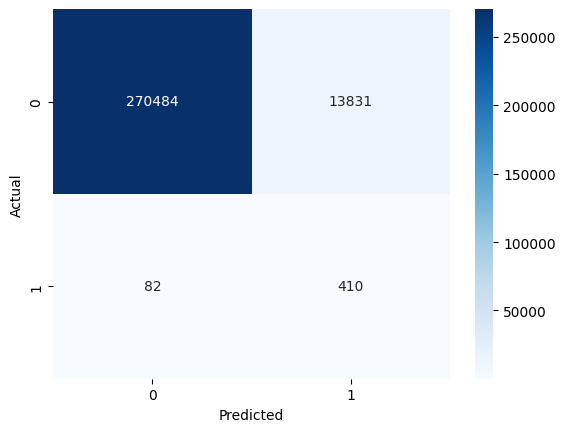

In [18]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


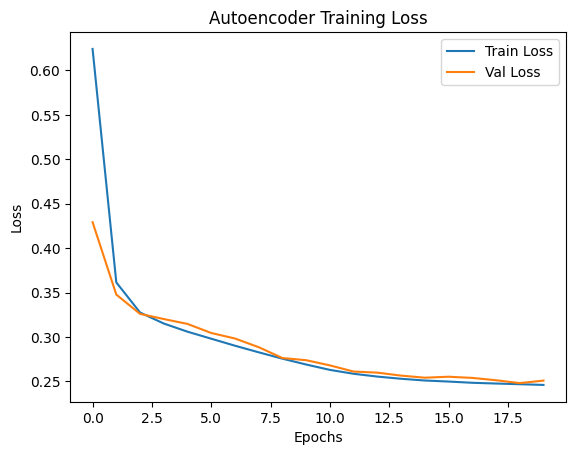

In [19]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Autoencoder Training Loss")
plt.show()